In [35]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

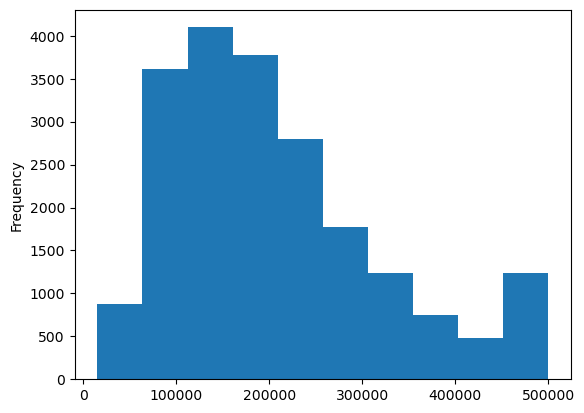

In [36]:
# Load the data.
# Look at the median_house_value variable. Does it have a long tail?
df=pd.read_csv('housing.csv')
df['median_house_value'].plot(kind='hist');

In [37]:
# For this homework, we only want to use a subset of data.

# First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'

# Next, use only the following columns:

# 'latitude',
# 'longitude',
# 'housing_median_age',
# 'total_rooms',
# 'total_bedrooms',
# 'population',
# 'households',
# 'median_income',
# 'median_house_value'



df=df.query("""
 ocean_proximity in ('<1H OCEAN','INLAND')

"""
)

df['ocean_proximity'].unique()

df=df[['latitude',
'longitude',
'housing_median_age',
'total_rooms',
'total_bedrooms',
'population',
'households',
'median_income',
'median_house_value'
]]

df.columns


Index(['latitude', 'longitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')

In [38]:
# Q1 There's one feature with missing values. What is it?
df.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

In [39]:
# Q2 What's the median (50% percentile) for variable 'population'

df['population'].describe()

count    15687.000000
mean      1466.317205
std       1180.389908
min          3.000000
25%        802.000000
50%       1195.000000
75%       1777.000000
max      35682.000000
Name: population, dtype: float64

In [40]:
# Shuffle the dataset (the filtered one you created above), use seed 42.
n=len(df)
idx=np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)



In [41]:
# Split your data in train/val/test sets, with 60%/20%/20% distribution.


n_val= int(n*0.2)
n_test= int(n*0.2)
n_train= int (n-n_val-n_test)
#print(n_train,n_val,n_val)

df_train=df.iloc[idx[:n_train]]
df_val= df.iloc[idx[n_train:n_val+n_train]]
df_test=df.iloc[idx[n_train+n_val:]]
#print(len(df_train),len(df_val),len(df_test))


In [42]:
# Apply the log transformation to the median_house_value variable using the np.log1p() function

y_train=np.log1p(df_train.median_house_value.values)
y_val= np.log1p(df_val.median_house_value.values)
y_test=np.log1p(df_test.median_house_value.values)

In [43]:
y_train

array([11.16196275, 12.32163544, 12.4718963 , ..., 13.12236738,
       12.11888489, 12.52924613])

In [44]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [45]:
df_train.columns

Index(['latitude', 'longitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')

In [46]:
# We need to deal with missing values for the column from Q1.
# We have two options: fill it with 0 or with the mean of this variable.

df_train_O=df_train.fillna(0)
df_train_m=df_train.fillna(df_train['total_bedrooms'].mean())


df_val_O=df_val.fillna(0)
df_val_m=df_val.fillna(df_train['total_bedrooms'].mean())

In [47]:
# Try both options. For each, train a linear regression model without regularization using the code from the lessons.
# For computing the mean, use the training only!

def train_linear_regression(X,y):
    ones=np.ones(X.shape[0])
    X=np.column_stack([ones,X])
    
    
    XTX=X.T.dot(X)
    XTX_inv =np.linalg.inv(XTX)
    w_full=XTX_inv.dot(X.T).dot(y)
    
    
    return w_full[0],w_full[1:]

In [48]:
w0,w=train_linear_regression(df_train_O.values,y_train)
w0_m,w_m=train_linear_regression(df_train_m,y_train)

#Use the validation dataset to evaluate the models and compare the RMSE of each option.
y_pred_0=w0+df_val_O.dot(w)
y_pred_m=w0_m+df_val_m.dot(w_m)

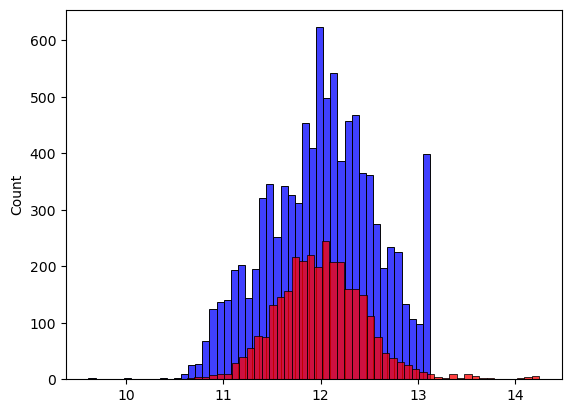

In [49]:
sns.histplot(y_train,color='blue',legend='Target')
sns.histplot(y_pred_0,color='red',legend='Prediction');

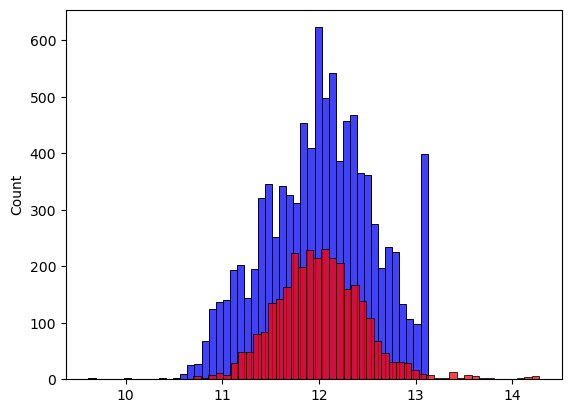

In [50]:
sns.histplot(y_train,color='blue',legend='Target')
sns.histplot(y_pred_m,color='red',legend='Prediction');

In [51]:
def rmse(y,y_pred):
    se= (y-y_pred)**2
    mse=se.mean()
    return np.sqrt(mse)

In [52]:
# Use the validation dataset to evaluate the models and compare the RMSE of each option.
# Round the RMSE scores to 2 decimal digits using round(score, 2)
print(round(rmse(y_val,y_pred_0),2))
print(round(rmse(y_val,y_pred_m),2))

0.34
0.34


In [53]:
# Now let's train a regularized linear regression.
# For this question, fill the NAs with 0.
# Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
# Use RMSE to evaluate the model on the validation dataset.
# Round the RMSE scores to 2 decimal digits.
# Which r gives the best RMSE?
# If there are multiple options, select the smallest r


def train_linear_regression_reg(X,y,r=0.01):
    ones=np.ones(X.shape[0])
    X=np.column_stack([ones,X])
    
    
    XTX=X.T.dot(X)
    XTX=XTX+r*np.eye(XTX.shape[0])
    XTX_inv =np.linalg.inv(XTX)
    w_full=XTX_inv.dot(X.T).dot(y)
    
    
    return w_full[0],w_full[1:]

In [54]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w0_r,w_r=train_linear_regression_reg(df_train_O,y_train,r=r)
    y_pred_r=w0_r+df_val_O.dot(w_r)
    score=rmse(y_pred_r,y_val)
    print(r,round(score,2))

0 0.34
1e-06 0.34
0.0001 0.34
0.001 0.34
0.01 0.34
0.1 0.34
1 0.34
5 0.35
10 0.35


In [61]:
# We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
# Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
# For each seed, do the train/validation/test split with 60%/20%/20% distribution.
# Fill the missing values with 0 and train a model without regularization.
# For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
# What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
# Round the result to 3 decimal digits (round(std, 3))

ss=[]
for s in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    n=len(df)
    idx=np.arange(n)
    np.random.seed(s)
    np.random.shuffle(idx)
    
    n_val= int(n*0.2)
    n_test= int(n*0.2)
    n_train= int (n-n_val-n_test)


    df_train=df.iloc[idx[:n_train]]
    df_val= df.iloc[idx[n_train:n_val+n_train]]
    df_test=df.iloc[idx[n_train+n_val:]]
    
    y_train=np.log1p(df_train.median_house_value.values)
    y_val= np.log1p(df_val.median_house_value.values)
    y_test=np.log1p(df_test.median_house_value.values)

    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']

    df_train_O=df_train.fillna(0)
    df_val_O=df_val.fillna(0)

    w0,w=train_linear_regression(df_train_O.values,y_train)
    y_pred_0=w0+df_val_O.dot(w)
    
    scores=rmse(y_val,y_pred_0)
    ss.append(scores)
std=round(np.std(np.array(ss)),3)

In [62]:
print(std)

0.005


In [30]:
#Split the dataset like previously, use seed 9.
#Combine train and validation datasets.
#Fill the missing values with 0 and train a model with r=0.001.
#What's the RMSE on the test dataset?

n=len(df)
idx=np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)
    
n_val= int(n*0.2)
n_test= int(n*0.2)
n_train= int (n-n_val-n_test)


df_train=df.iloc[idx[:n_train]]
df_val= df.iloc[idx[n_train:n_val+n_train]]
df_test=df.iloc[idx[n_train+n_val:]]
df_concat=df.iloc[idx[:n_train+n_val]]

y_train=np.log1p(df_train.median_house_value.values)
y_val= np.log1p(df_val.median_house_value.values)
y_test=np.log1p(df_test.median_house_value.values)
y_concat=np.log1p(df_concat.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']
del df_concat['median_house_value']

df_concat_O=df_concat.fillna(0)
df_test_O=df_test.fillna(0)

w0,w=train_linear_regression_reg(df_concat_O,y_concat,r=0.001)
y_pred_O=w0+df_test_O.dot(w)

round(rmse(y_test,y_pred_O),2)

0.33